# 02 · Validación Sintética de Registro
**Objetivo:** evaluar el pipeline de registro con pares sintéticos de transformaciones conocidas (rotación, traslación, escala) y medir error (RMSE de H y diferencia angular).

In [ ]:
import os

# Ir al root del repo (sube un nivel desde /notebooks)
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

import math
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

from src.feature_detection import detect_and_describe
from src.matching import match_descriptors
from src.registration import estimate_homography
from src.utils import synthetic_affine_pair, rmse

plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.grid'] = True

OUT_CSV = "results/measurements/synth_validation.csv"
FIG_DIR = "results/figures"
os.makedirs("results/measurements", exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

## 1) Generación de pares sintéticos

In [3]:
def make_base(h=320, w=420):
    img = np.zeros((h, w, 3), dtype=np.uint8)
    for x in range(30, w-30, 40):
        cv.circle(img, (x, h//2), 6, (255,255,255), -1)
    cv.putText(img, "REGISTRO", (30, 60), cv.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2, cv.LINE_AA)
    return img

base = make_base()

configs = [
    {"angle": 10, "tx": 20, "ty": 10, "scale": 1.00},
    {"angle": 15, "tx": -15, "ty": 5, "scale": 1.05},
    {"angle": -8, "tx": 30, "ty": -20, "scale": 0.95},
]

len(configs)

3

## 2) Registro y métricas

In [4]:
def estimate_angle_from_H(H):
    # Aproximación: ángulo a partir de submatriz rotacional normalizada
    a = math.degrees(math.atan2(H[1,0], H[0,0]))
    return a

rows = []
for cfg in configs:
    img1, img2, H_gt = synthetic_affine_pair(base, angle_deg=cfg["angle"], tx=cfg["tx"], ty=cfg["ty"], scale=cfg["scale"])
    # ORB por velocidad
    k1, d1 = detect_and_describe(img1, method="ORB")
    k2, d2 = detect_and_describe(img2, method="ORB")
    matches = match_descriptors(d1, d2, strategy="BF", ratio=0.75)
    if len(matches) < 4:
        rows.append({**cfg, "matches": len(matches), "inliers": 0, "rmse_H": None, "angle_err_deg": None})
        continue
    H_est, mask = estimate_homography(k1, k2, matches, ransac_thresh=3.0)
    r = {
        **cfg,
        "matches": len(matches),
        "inliers": int(mask.sum()) if mask is not None else None,
        "rmse_H": rmse(H_est, H_gt),
        "angle_err_deg": abs(estimate_angle_from_H(H_est) - cfg["angle"])
    }
    rows.append(r)

df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
df

,angle,tx,ty,scale,matches,inliers,rmse_H,angle_err_deg
0,10,20,10,1.00,263,183,1.720061,19.939709
1,15,-15,5,1.05,162,108,1.051362,30.548018
2,-8,30,-20,0.95,132,44,9.343724,15.380355


## 3) Visualización rápida (un caso)

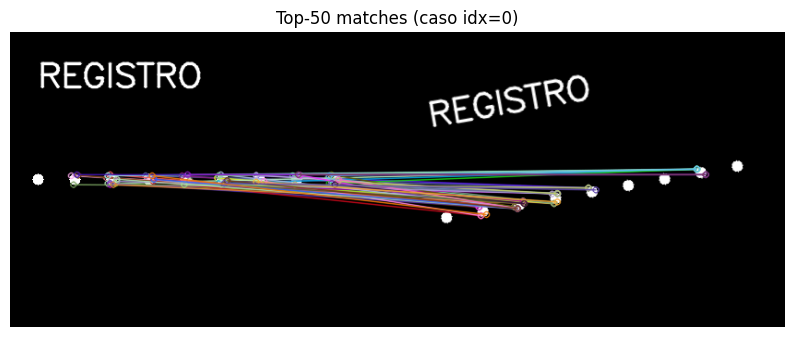

In [5]:
idx = 0
img1, img2, H_gt = synthetic_affine_pair(base, angle_deg=configs[idx]["angle"], tx=configs[idx]["tx"], ty=configs[idx]["ty"], scale=configs[idx]["scale"])
k1, d1 = detect_and_describe(img1, method="ORB")
k2, d2 = detect_and_describe(img2, method="ORB")
matches = match_descriptors(d1, d2, strategy="BF", ratio=0.75)
vis = cv.drawMatches(img1, k1, img2, k2, matches[:50], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB)); plt.title("Top-50 matches (caso idx=0)"); plt.axis('off'); plt.show()